In [15]:
import torch
import numpy as np
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
from Dataset import Dataset, ELM, device
torch.set_default_dtype(torch.float64)

In [16]:
train = loadmat('data_training_reactor_pol.mat')
test = loadmat('data_validation_reactor_pol.mat')

y_train = 0.0001*(train['NAMW'][0]-train['NAMW'][0][0])
y_test = 0.0001*(test['NAMW'][0]-test['NAMW'][0][0])

x_train = np.concatenate((100*np.concatenate(([[0]], (train['FI'].T[1:]-train['FI'].T[0])), axis=0),
                          100*np.concatenate(([[0], [0]], (train['FI'].T[2:]-train['FI'].T[0])), axis=0),
                          np.concatenate(([0], y_train[1:]), axis=0).reshape(-1, 1),
                          np.concatenate(([0, 0], y_train[2:]), axis=0).reshape(-1, 1)), axis=1)

x_test = np.concatenate((100*np.concatenate(([[0]], (test['FI'].T[1:]-test['FI'].T[0])), axis=0),
                         100*np.concatenate(([[0], [0]], (test['FI'].T[2:]-test['FI'].T[0])), axis=0),
                         np.concatenate(([0], y_test[1:]), axis=0).reshape(-1, 1),
                         np.concatenate(([0, 0], y_test[2:]), axis=0).reshape(-1, 1)), axis=1)

In [17]:
trainset = Dataset(x_train, y_train)
testset = Dataset(x_test, y_test)

activation = nn.Sigmoid()

In [18]:
model = ELM(4, 50, 1).to(device)

H = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].T.to(device))
T = trainset[:][1].reshape(1, -1).T.to(device)

In [19]:
def K(x):
    if x.dtype != torch.float64:
        x = torch.tensor(x, dtype=torch.float64).reshape(-1, 1).to(device)
    out = torch.exp(-torch.cdist(x, trainset[:][0].reshape(-1, 1).to(device), p=2) ** 2) @ T
    return out/max(out)

Train error: 0.41623865748176253
Test error: 0.3519009379688086


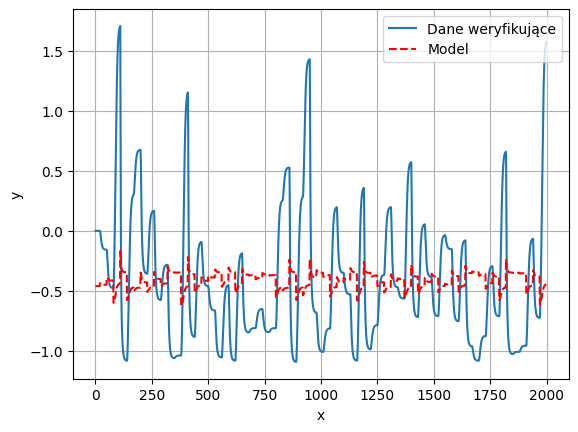

In [20]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 4).to(device))-trainset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 4).to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
plt.plot(y_test)
plt.plot(model(torch.tensor(x_test).reshape(-1, 4).to(device)).cpu().detach().numpy(), 'r--')
plt.legend(['Dane weryfikujące', 'Model'], loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

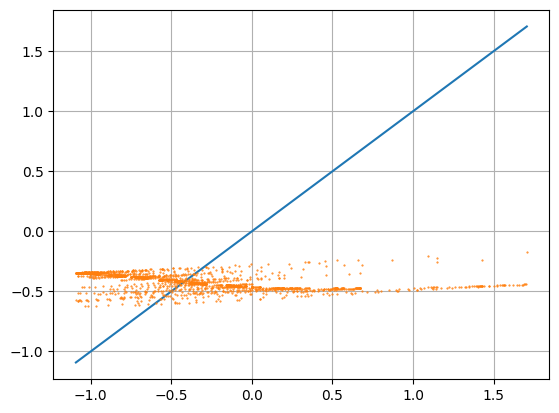

In [21]:
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)])
plt.plot(y_test, model(torch.tensor(x_test).reshape(-1, 4).to(device)).cpu().detach().numpy(), '.', markersize=1)
plt.grid()
plt.show()